In [19]:
import tensorflow as tf
import pandas as pd
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Sentiment_news_dataframe.csv')



In [3]:
# Drop irrelevant columns
df = df.drop(['Date', 'URL', 'confidence', 'Unnamed: 5'], axis=1)

# Drop duplicates in column "Title"
df = df.drop_duplicates(subset=["Title"])


In [4]:
# Rename columns
df = df.rename(columns={'Title': 'text', 'sentiment': 'Label'})


In [5]:
# Convert labels to integers
df['Label'] = df['Label'].apply(lambda x: 1 if x == "POSITIVE" else 0)


In [6]:
# Split the dataset into training and validation sets
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)


In [7]:
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [8]:
# Encode the training and validation sets
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True)
val_encodings = tokenizer(list(val_df['text']), truncation=True, padding=True)


In [9]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df['Label']))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_df['Label']))


In [12]:
# Load the pre-trained DistilBERT model
model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [13]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [14]:
# Compile the model
model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [15]:
# Train the model
model2.fit(train_dataset.shuffle(len(train_df)).batch(32), epochs=2, batch_size=32, validation_data=val_dataset.batch(32))

Epoch 1/2
1500/1500 [==============================] - 11710s 8s/step - loss: 0.3645 - accuracy: 0.8332 - val_loss: 0.3141 - val_accuracy: 0.8628
Epoch 2/2
1500/1500 [==============================] - 11609s 8s/step - loss: 0.1948 - accuracy: 0.9205 - val_loss: 0.3754 - val_accuracy: 0.8551


In [17]:
# Evaluate the model on the training set
train_loss, train_acc = model2.evaluate(train_dataset.batch(32))
print("Train accuracy:", train_acc)

# Evaluate the model on the validation set
val_loss, val_acc = model2.evaluate(val_dataset.batch(32))
print("Test accuracy:", val_acc)


1500/1500 [==============================] - 3557s 2s/step - loss: 0.0828 - accuracy: 0.9734
Train accuracy: 0.9734044671058655
375/375 [==============================] - 718s 2s/step - loss: 0.3754 - accuracy: 0.8551
Test accuracy: 0.8551062941551208


In [21]:

# Get predictions
y_pred_logits = model2.predict(val_dataset.batch(32))
y_pred = np.argmax(y_pred_logits.logits, axis=1)


375/375 [==============================] - 1004s 3s/step


In [23]:
# Calculate evaluation metrics
print(classification_report(val_df['Label'], y_pred))


              precision    recall  f1-score   support

           0       0.91      0.79      0.85      6091
           1       0.81      0.92      0.86      5904

    accuracy                           0.86     11995
   macro avg       0.86      0.86      0.85     11995
weighted avg       0.86      0.86      0.85     11995



In [25]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(val_df['Label'], y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)


Precision: 0.8111741858380639
Recall: 0.9197154471544715
F1 score: 0.8620415939037942


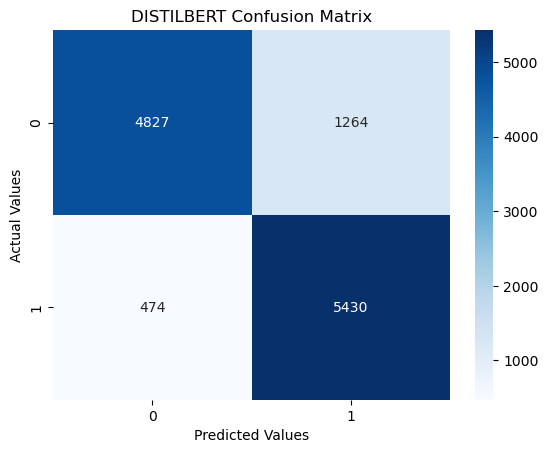

In [27]:
conf_matrix = confusion_matrix(val_df['Label'], y_pred)
# Visualize confusion matrix with heatmap
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('DISTILBERT Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

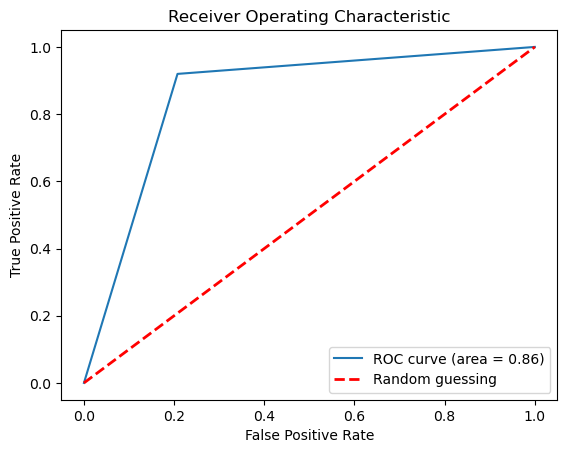

In [29]:
# Calculate ROC curve and AUC

fpr, tpr, thresholds = roc_curve(val_df['Label'], y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()
